# Coursework Project
Data Pre-Processing for a Sales Forecasting Problem

Forecasting Sales

DATA71011 Understanding Data and their Environment

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
FINALdata = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Understanding Data and their Environment/Assignment 2/final-data/forecastingFINALdata.csv')

In [4]:
# Filter final training and testing sets
# Filtering data for each category
trainingSet = FINALdata[FINALdata['Set'] == 'Training'].copy()
testingSet = FINALdata[FINALdata['Set'] == 'Testing'].copy()

## 1. Preparing Training Set

In [6]:
# As Date format:
trainingSet['Date'] = pd.to_datetime(trainingSet['Date'])

# Sorted df:
trainingSet = trainingSet.sort_values(by=['Store', 'Date'])

# Filter only open stores:
trainingSet = trainingSet[trainingSet['Open'] == 1]

In [7]:
trainingSet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 217 to 1016970
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                844392 non-null  int64         
 1   Date                 844392 non-null  datetime64[ns]
 2   Sales                844392 non-null  float64       
 3   Customers            844392 non-null  float64       
 4   Open                 844392 non-null  float64       
 5   Promo                844392 non-null  int64         
 6   SchoolHoliday        844392 non-null  int64         
 7   CompetitionDistance  844392 non-null  int64         
 8   Promo2               844392 non-null  int64         
 9   DiffTimeMonths       844392 non-null  int64         
 10  DiffPromoTimeMonths  844392 non-null  int64         
 11  Set                  844392 non-null  object        
 12  DayOfWeek_2          844392 non-null  int64         
 13  DayOfWeek_3     

In [8]:
# Create lags for 1 day and 7 days
for lag in [1, 7]:
    trainingSet[f'Sales_Lag_{lag}'] = trainingSet.groupby('Store')['Sales'].shift(lag)

trainingSet['Rolling_Mean_7'] = trainingSet.groupby('Store')['Sales'].transform(lambda x: x.shift(1).rolling(7).mean())

In [9]:
# Count NaN values in lagged features
lagged_nan_counts = trainingSet[['Sales_Lag_1', 'Sales_Lag_7','Rolling_Mean_7']].isnull().sum()
trainingSet = trainingSet.dropna(subset=['Sales_Lag_1', 'Sales_Lag_7', 'Rolling_Mean_7'])

# Display NaN counts for lagged features
print(lagged_nan_counts)

Sales_Lag_1       1115
Sales_Lag_7       7805
Rolling_Mean_7    7805
dtype: int64


#### 1.1. Scaling Numerical Features

In [11]:
from sklearn.preprocessing import MinMaxScaler

# List numerical variables to standardize
numerical_features = [
    'CompetitionDistance', 'DiffTimeMonths', 'DiffPromoTimeMonths', 'Sales_Lag_1', 'Sales_Lag_7', 'Rolling_Mean_7'
]

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ensure numerical features are cast to float64
trainingSet[numerical_features] = scaler.fit_transform(trainingSet[numerical_features])

In [12]:
trainingSet.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,DiffTimeMonths,...,StateHoliday_3,StateHoliday_4,StoreType_2,StoreType_3,StoreType_4,Assortment_2,Assortment_3,Sales_Lag_1,Sales_Lag_7,Rolling_Mean_7
45,1,2013-01-10,4892.0,615.0,1.0,1,1,0.016482,0,0.059163,...,0,0,0,1,0,0,0,0.131670,0.133089,0.137957
23,1,2013-01-11,4881.0,592.0,1.0,1,1,0.016482,0,0.059163,...,0,0,0,1,0,0,0,0.117735,0.104137,0.134958
1,1,2013-01-12,4952.0,646.0,1.0,0,0,0.016482,0,0.059163,...,0,0,0,1,0,0,0,0.117470,0.107964,0.137562
688,1,2013-01-14,4717.0,616.0,1.0,0,0,0.016482,0,0.059163,...,0,0,0,1,0,0,0,0.119179,0.120262,0.139752
789,1,2013-01-15,3900.0,512.0,1.0,0,0,0.016482,0,0.059163,...,0,0,0,1,0,0,0,0.113523,0.172703,0.138436


#### 1.2. Exploring High-Correlated Features

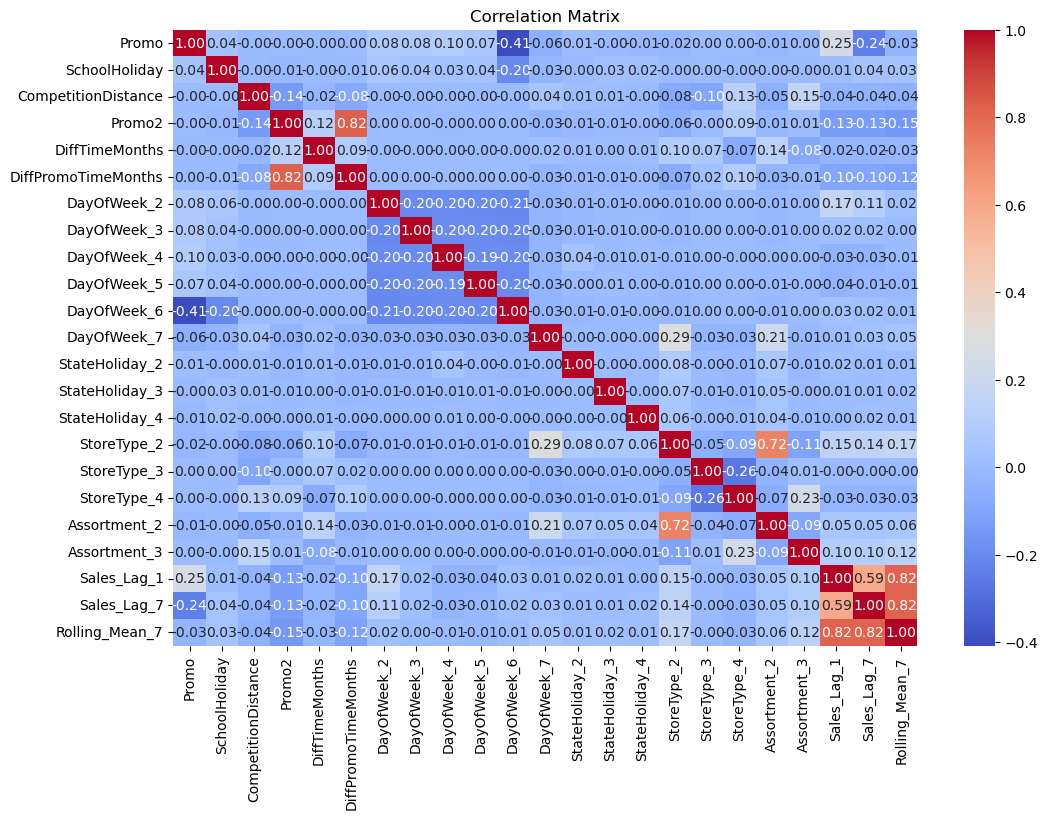

In [14]:
# Dropping ID columns
corrMatrix = trainingSet.drop(['Store','Sales','Date','Customers','Open','Set'], axis='columns')

# Compute the correlation matrix
correlation_matrix = corrMatrix.corr()

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## 2. Training the Model

### 2.1. Divide Data into Training and Testing Sets

In [17]:
from sklearn.model_selection import train_test_split

# Ensure data is sorted by Date
trainingSet = trainingSet.sort_values(by='Date')

# Define cutoff date for training and testing split
cutoff_date = '2015-01-01'

# Split into training and testing sets
train_data = trainingSet[trainingSet['Date'] < cutoff_date]
test_data = trainingSet[trainingSet['Date'] >= cutoff_date]

# Separate features and target
X_train = train_data.drop(columns=['Store','Sales','Date','Customers','Open','Set'])
y_train = train_data['Sales']

X_test = test_data.drop(columns=['Store','Sales','Date','Customers','Open','Set'])
y_test = test_data['Sales']

# Print shapes to confirm
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (640555, 23)
X_test shape: (196032, 23)


In [18]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define RMSPE function
def rmspe(y_true, y_pred):
    non_zero_mask = y_true != 0  # Avoid division by zero
    percentage_errors = ((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) ** 2
    return np.sqrt(np.mean(percentage_errors))

# Create custom RMSPE scorer
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

#### 2.2. Training with all Features

#### OLS

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score

# Define RMSPE scoring
def rmspe(y_true, y_pred):
    non_zero_mask = y_true != 0
    percentage_errors = ((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) ** 2
    return np.sqrt(np.mean(percentage_errors))

# Initialize OLS (LinearRegression)
ols = LinearRegression()

# Train the OLS model on the training set
ols.fit(X_train, y_train)

# Predict on the test set
y_test_pred = ols.predict(X_test)

# Evaluate RMSPE on the test set
test_rmspe = rmspe(y_test, y_test_pred)

# Evaluate R² on the test set
test_r2 = r2_score(y_test, y_test_pred)

# Output the results
print(f"RMSPE on Test Set: {test_rmspe:.4f}")
print(f"R² on Test Set: {test_r2:.4f}")


RMSPE on Test Set: 0.2795
R² on Test Set: 0.7681


#### Ridge

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Define RMSPE scoring function
def rmspe(y_true, y_pred):
    non_zero_mask = y_true != 0
    percentage_errors = ((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) ** 2
    return np.sqrt(np.mean(percentage_errors))

# Create custom RMSPE scorer
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Define parameter grid for alpha
param_grid = {'alpha': [0.1, 1, 10, 100, 1000]}

# Initialize Ridge Regression with GridSearchCV
ridge_grid = GridSearchCV(Ridge(), param_grid, scoring=rmspe_scorer, cv=5)

# Perform CV and hyperparameter tuning on the training set
ridge_grid.fit(X_train, y_train)

# Retrieve the best Ridge model
best_ridge = ridge_grid.best_estimator_

# Predict on the test set
y_test_pred = best_ridge.predict(X_test)

# Evaluate RMSPE on the test set
test_rmspe = rmspe(y_test, y_test_pred)

# Evaluate R² on the test set
test_r2 = r2_score(y_test, y_test_pred)

# Output results
print(f"Best alpha: {ridge_grid.best_params_['alpha']}")
print(f"RMSPE on Test Set: {test_rmspe:.4f}")
print(f"R² on Test Set: {test_r2:.4f}")

Best alpha: 0.1
RMSPE on Test Set: 0.2795
R² on Test Set: 0.7681


#### LASSO

In [25]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Define RMSPE scoring
def rmspe(y_true, y_pred):
    non_zero_mask = y_true != 0
    percentage_errors = ((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) ** 2
    return np.sqrt(np.mean(percentage_errors))

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Define parameter grid for alpha
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

# Initialize Lasso with GridSearchCV
lasso_grid = GridSearchCV(Lasso(max_iter=10000), param_grid, scoring=rmspe_scorer, cv=5)

# Perform CV and hyperparameter tuning
lasso_grid.fit(X_train, y_train)

# Retrieve the best Lasso model
best_lasso = lasso_grid.best_estimator_

# Predict on the test set
y_test_pred = best_lasso.predict(X_test)

# Evaluate RMSPE on the test set
test_rmspe = rmspe(y_test, y_test_pred)

# Evaluate R² on the test set
test_r2 = r2_score(y_test, y_test_pred)

# Output results
print(f"Best alpha: {lasso_grid.best_params_['alpha']}")
print(f"RMSPE on Test Set: {test_rmspe:.4f}")
print(f"R² on Test Set: {test_r2:.4f}")

Best alpha: 0.0001
RMSPE on Test Set: 0.2795
R² on Test Set: 0.7681


In [26]:
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

# Define RMSPE scoring
def rmspe(y_true, y_pred):
    non_zero_mask = y_true != 0
    percentage_errors = ((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) ** 2
    return np.sqrt(np.mean(percentage_errors))

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Adjust grid size
param_grid = {
    'hidden_layer_sizes': [(64,), (128,)],  # Fewer configurations
    'activation': ['relu'],  # Focus on one activation function
    'solver': ['adam'],  # Keep one solver
    'alpha': [0.0001, 0.001],  # Smaller range of regularization values
    'learning_rate': ['constant'],  # Fix learning rate
}

# Initialize MLPRegressor
mlp = MLPRegressor(max_iter=1000, random_state=42)

# Perform GridSearchCV
mlp_grid = GridSearchCV(mlp, param_grid, scoring=rmspe_scorer, cv=5, n_jobs=-1)
mlp_grid.fit(X_train, y_train)

# Best model
best_mlp = mlp_grid.best_estimator_

# Test set evaluation
y_test_pred = best_mlp.predict(X_test)
test_rmspe = rmspe(y_test, y_test_pred)

# Calculate R²
test_r2 = r2_score(y_test, y_test_pred)

# Output results
print(f"Best hyperparameters: {mlp_grid.best_params_}")
print(f"RMSPE on Test Set: {test_rmspe:.4f}")
print(f"R² on Test Set: {test_r2:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_netwo

Best hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128,), 'learning_rate': 'constant', 'solver': 'adam'}
RMSPE on Test Set: 0.2159
R² on Test Set: 0.8430


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Selected Features

In [44]:
# Final train set:
columns_drop = [
    'Promo2','SchoolHoliday','StateHoliday_2','StateHoliday_3','StateHoliday_4' 
]
# Drop the columns
trainSet_SF = trainingSet.drop(columns=columns_drop)
trainSet_SF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 836587 entries, 700194 to 1016970
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                836587 non-null  int64         
 1   Date                 836587 non-null  datetime64[ns]
 2   Sales                836587 non-null  float64       
 3   Customers            836587 non-null  float64       
 4   Open                 836587 non-null  float64       
 5   Promo                836587 non-null  int64         
 6   CompetitionDistance  836587 non-null  float64       
 7   DiffTimeMonths       836587 non-null  float64       
 8   DiffPromoTimeMonths  836587 non-null  float64       
 9   Set                  836587 non-null  object        
 10  DayOfWeek_2          836587 non-null  int64         
 11  DayOfWeek_3          836587 non-null  int64         
 12  DayOfWeek_4          836587 non-null  int64         
 13  DayOfWeek_5  

In [46]:
# Ensure data is sorted by Date
trainSet_SF = trainSet_SF.sort_values(by='Date')

# Define cutoff date for training and testing split
cutoff_date = '2015-01-01'

# Split into training and testing sets
train_data_SF = trainSet_SF[trainSet_SF['Date'] < cutoff_date]
test_data_SF = trainSet_SF[trainSet_SF['Date'] >= cutoff_date]

# Separate features and target
X_train_SF = train_data_SF.drop(columns=['Store','Sales','Date','Customers','Open','Set'])
y_train_SF = train_data_SF['Sales']

X_test_SF = test_data_SF.drop(columns=['Store','Sales','Date','Customers','Open','Set'])
y_test_SF = test_data_SF['Sales']

# Print shapes to confirm
print(f"X_train_SF shape: {X_train_SF.shape}")
print(f"X_test_SF shape: {X_test_SF.shape}")

X_train_SF shape: (640555, 18)
X_test_SF shape: (196032, 18)


#### OLS

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score

# Define RMSPE scoring
def rmspe(y_true, y_pred):
    non_zero_mask = y_true != 0
    percentage_errors = ((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) ** 2
    return np.sqrt(np.mean(percentage_errors))

# Initialize OLS (LinearRegression)
ols = LinearRegression()

# Train the OLS model on the training set with selected features
ols.fit(X_train_SF, y_train_SF)

# Predict on the test set with selected features
y_test_pred_SF = ols.predict(X_test_SF)

# Evaluate RMSPE on the test set
test_rmspe_SF = rmspe(y_test_SF, y_test_pred_SF)

# Evaluate R² on the test set
test_r2_SF = r2_score(y_test_SF, y_test_pred_SF)

# Output the results
print(f"RMSPE on Test Set: {test_rmspe_SF:.4f}")
print(f"R² on Test Set: {test_r2_SF:.4f}")


RMSPE on Test Set: 0.2795
R² on Test Set: 0.7684


#### Ridge Regression

In [52]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Define RMSPE scoring
def rmspe(y_true, y_pred):
    non_zero_mask = y_true != 0
    percentage_errors = ((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) ** 2
    return np.sqrt(np.mean(percentage_errors))

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Define parameter grid for alpha
param_grid = {'alpha': [0.1, 1, 10, 100, 1000]}

# Initialize Ridge Regression with GridSearchCV
ridge_grid = GridSearchCV(Ridge(), param_grid, scoring=rmspe_scorer, cv=5)

# Perform CV and hyperparameter tuning on the training set with selected features
ridge_grid.fit(X_train_SF, y_train_SF)

# Retrieve the best Ridge model
best_ridge_SF = ridge_grid.best_estimator_

# Predict on the test set with selected features
y_test_pred_SF = best_ridge_SF.predict(X_test_SF)

# Evaluate RMSPE on the test set
test_rmspe_SF = rmspe(y_test_SF, y_test_pred_SF)

# Evaluate R² on the test set
test_r2_SF = r2_score(y_test_SF, y_test_pred_SF)

# Output the results
print(f"Best alpha: {ridge_grid.best_params_['alpha']}")
print(f"RMSPE on Test Set: {test_rmspe_SF:.4f}")
print(f"R² on Test Set: {test_r2_SF:.4f}")


Best alpha: 10
RMSPE on Test Set: 0.2795
R² on Test Set: 0.7683


#### Lasso Regression

In [55]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Define RMSPE scoring
def rmspe(y_true, y_pred):
    non_zero_mask = y_true != 0
    percentage_errors = ((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) ** 2
    return np.sqrt(np.mean(percentage_errors))

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Define parameter grid for alpha
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

# Initialize Lasso with GridSearchCV
lasso_grid = GridSearchCV(Lasso(max_iter=10000), param_grid, scoring=rmspe_scorer, cv=5)

# Perform CV and hyperparameter tuning on the training set with selected features
lasso_grid.fit(X_train_SF, y_train_SF)

# Retrieve the best Lasso model
best_lasso_SF = lasso_grid.best_estimator_

# Predict on the test set with selected features
y_test_pred_SF = best_lasso_SF.predict(X_test_SF)

# Evaluate RMSPE on the test set
test_rmspe_SF = rmspe(y_test_SF, y_test_pred_SF)

# Evaluate R² on the test set
test_r2_SF = r2_score(y_test_SF, y_test_pred_SF)

# Output the results
print(f"Best alpha: {lasso_grid.best_params_['alpha']}")
print(f"RMSPE on Test Set: {test_rmspe_SF:.4f}")
print(f"R² on Test Set: {test_r2_SF:.4f}")

Best alpha: 0.0001
RMSPE on Test Set: 0.2795
R² on Test Set: 0.7684


#### MLP

In [58]:
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

# Define RMSPE scoring
def rmspe(y_true, y_pred):
    non_zero_mask = y_true != 0
    percentage_errors = ((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) ** 2
    return np.sqrt(np.mean(percentage_errors))

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Adjust grid size
param_grid = {
    'hidden_layer_sizes': [(64,), (128,)],  # Fewer configurations
    'activation': ['relu'],  # Focus on one activation function
    'solver': ['adam'],  # Keep one solver
    'alpha': [0.0001, 0.001],  # Smaller range of regularization values
    'learning_rate': ['constant'],  # Fix learning rate
}

# Initialize MLPRegressor
mlp = MLPRegressor(max_iter=1000, random_state=42)

# Perform GridSearchCV
mlp_grid = GridSearchCV(mlp, param_grid, scoring=rmspe_scorer, cv=5, n_jobs=-1)
mlp_grid.fit(X_train_SF, y_train_SF)

# Best model
best_mlp_SF = mlp_grid.best_estimator_

# Test set evaluation
y_test_pred_SF = best_mlp_SF.predict(X_test_SF)
test_rmspe_SF = rmspe(y_test_SF, y_test_pred_SF)

# Calculate R²
test_r2_SF = r2_score(y_test_SF, y_test_pred_SF)

# Output results
print(f"Best hyperparameters: {mlp_grid.best_params_}")
print(f"RMSPE on Test Set: {test_rmspe_SF:.4f}")
print(f"R² on Test Set: {test_r2_SF:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_netwo

Best hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate': 'constant', 'solver': 'adam'}
RMSPE on Test Set: 0.2221
R² on Test Set: 0.8374


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Training Lasso with Complete Set

In [61]:
trainingSet.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,DiffTimeMonths,...,StateHoliday_3,StateHoliday_4,StoreType_2,StoreType_3,StoreType_4,Assortment_2,Assortment_3,Sales_Lag_1,Sales_Lag_7,Rolling_Mean_7
700194,769,2013-01-08,7659.0,2295.0,1.0,1,0,0.010812,1,0.178932,...,0,0,1,0,0,1,0,0.200067,0.121176,0.190945
667438,733,2013-01-08,12577.0,2921.0,1.0,1,0,0.011076,0,0.136364,...,0,0,1,0,0,1,0,0.309620,0.259079,0.350177
483445,530,2013-01-08,2649.0,336.0,1.0,1,0,0.239188,0,0.017316,...,0,0,0,0,0,0,1,0.084763,0.069962,0.057114
320747,353,2013-01-08,2756.0,888.0,1.0,1,0,0.011603,1,0.178932,...,0,0,1,0,0,1,0,0.072489,0.075546,0.056790
248949,274,2013-01-08,1580.0,480.0,1.0,1,1,0.047732,1,0.115440,...,0,0,1,0,0,1,0,0.046569,0.074655,0.039533


In [63]:
from sklearn.neural_network import MLPRegressor

# Extract features and target from the training set
X_full = trainingSet.drop(columns=['Store','Sales','Date','Customers','Open','Set','Promo2','SchoolHoliday','StateHoliday_2','StateHoliday_3','StateHoliday_4'])
y_full = trainingSet['Sales']  # Define the target variable

# Initialize the MLP model with the best hyperparameters
best_mlp_SF = MLPRegressor(
    hidden_layer_sizes=(128,),      # Number of neurons in the hidden layer
    activation='relu',              # Activation function
    solver='adam',                  # Optimizer
    alpha=0.0001,                   # Regularization parameter (L2 penalty)
    learning_rate='constant',       # Learning rate schedule
    max_iter=1000,                  # Set high iterations to ensure convergence
    random_state=42                 # Seed for reproducibility
)

# Train the MLP model on the full training set
best_mlp_SF.fit(X_full, y_full)

y_pred = best_mlp_SF.predict(X_full)
full_r2 = r2_score(y_full, y_pred)

# Output trained Lasso model
print("MLP model trained with alpha = 0.0001 and 128 neurons in hidden layer")
print(full_r2)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP model trained with alpha = 0.0001 and 128 neurons in hidden layer
0.8341268746704131


In [65]:
results_df = pd.DataFrame({
    'Observed Sales': y_full,
    'Predicted Sales': y_pred
})
results_df.head()

,Observed Sales,Predicted Sales
700194,7659.0,6934.713881
667438,12577.0,12133.621908
483445,2649.0,3392.590572
320747,2756.0,2060.371027
248949,1580.0,1422.054551


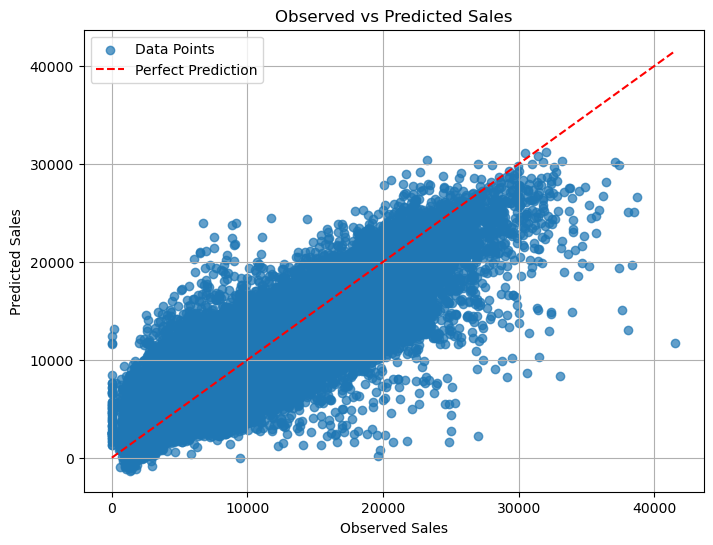

In [67]:
# Scatterplot of predicted vs observed values with improved labeling and diagonal reference line
plt.figure(figsize=(8, 6))
plt.scatter(results_df['Observed Sales'], results_df['Predicted Sales'], alpha=0.7, label="Data Points")
plt.plot(
    [results_df['Observed Sales'].min(), results_df['Observed Sales'].max()],
    [results_df['Observed Sales'].min(), results_df['Observed Sales'].max()],
    color='red', linestyle='--', label="Perfect Prediction"
)
plt.xlabel("Observed Sales")
plt.ylabel("Predicted Sales")
plt.title("Observed vs Predicted Sales")
plt.legend()
plt.grid(True)
plt.show()

### 4. Preparing Testing Set

In [70]:
# As Date format:
testingSet['Date'] = pd.to_datetime(testingSet['Date'])

# Sorted df:
testingSet = testingSet.sort_values(by=['Store', 'Date']).reset_index(drop=True)

# Only open stores:
testingSet = testingSet[testingSet['Open'] == 1]

In [72]:
trainingSetFINAL = FINALdata[FINALdata['Set'] == 'Training'].copy()
trainingSetFINAL = trainingSetFINAL[trainingSetFINAL['Open'] == 1]
trainingSetFINAL = trainingSetFINAL.sort_values(by=['Store', 'Date']).reset_index(drop=True)

In [74]:
trainingSetFINAL.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,DiffTimeMonths,...,DayOfWeek_6,DayOfWeek_7,StateHoliday_2,StateHoliday_3,StateHoliday_4,StoreType_2,StoreType_3,StoreType_4,Assortment_2,Assortment_3
0,1,2013-01-02,5530.0,668.0,1.0,0,1,1270,0,82,...,0,0,0,0,0,0,1,0,0,0
1,1,2013-01-03,4327.0,578.0,1.0,0,1,1270,0,82,...,0,0,0,0,0,0,1,0,0,0
2,1,2013-01-04,4486.0,619.0,1.0,0,1,1270,0,82,...,0,0,0,0,0,0,1,0,0,0
3,1,2013-01-05,4997.0,635.0,1.0,0,1,1270,0,82,...,1,0,0,0,0,0,1,0,0,0
4,1,2013-01-07,7176.0,785.0,1.0,1,1,1270,0,82,...,0,0,0,0,0,0,1,0,0,0


In [76]:
from sklearn.preprocessing import MinMaxScaler

# List numerical variables to standardize
numerical_features = [
    'CompetitionDistance', 'DiffTimeMonths', 'DiffPromoTimeMonths'
]

# Initialize the scaler and fit it on the trainingSet
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(trainingSetFINAL[numerical_features])  # Fit the scaler on the training set

# Transform both trainingSet and testingSet
testingSet[numerical_features] = scaler.transform(testingSet[numerical_features])

In [78]:
# Use the last available lagged features from the training set for each store
static_lagged_features = trainingSet.groupby('Store').tail(1)[['Store', 'Sales_Lag_1', 'Sales_Lag_7', 'Rolling_Mean_7']]

# Merge the lagged features into the testingSet
testingSet = testingSet.merge(static_lagged_features, on='Store', how='left')

In [82]:
testingSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35093 entries, 0 to 35092
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Store                35093 non-null  int64         
 1   Date                 35093 non-null  datetime64[ns]
 2   Sales                0 non-null      float64       
 3   Customers            0 non-null      float64       
 4   Open                 35093 non-null  float64       
 5   Promo                35093 non-null  int64         
 6   SchoolHoliday        35093 non-null  int64         
 7   CompetitionDistance  35093 non-null  float64       
 8   Promo2               35093 non-null  int64         
 9   DiffTimeMonths       35093 non-null  float64       
 10  DiffPromoTimeMonths  35093 non-null  float64       
 11  Set                  35093 non-null  object        
 12  DayOfWeek_2          35093 non-null  int64         
 13  DayOfWeek_3          35093 non-

In [86]:
# Prepare features for prediction
X_test = testingSet.drop(columns=['Store','Sales','Date','Customers','Open','Set','Promo2','SchoolHoliday','StateHoliday_2','StateHoliday_3','StateHoliday_4'])

# Predict sales for the test set
testingSet['Sales'] = best_mlp_SF.predict(X_test)

In [88]:
testingSet.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,DiffTimeMonths,...,StateHoliday_3,StateHoliday_4,StoreType_2,StoreType_3,StoreType_4,Assortment_2,Assortment_3,Sales_Lag_1,Sales_Lag_7,Rolling_Mean_7
0,1,2015-08-01,4396.667652,NaN,1.0,0,1,0.016482,0,0.059163,...,0,0,0,1,0,0,0,0.120815,0.090708,0.115338
1,1,2015-08-03,7946.196776,NaN,1.0,1,1,0.016482,0,0.059163,...,0,0,0,1,0,0,0,0.120815,0.090708,0.115338
2,1,2015-08-04,4937.124293,NaN,1.0,1,1,0.016482,0,0.059163,...,0,0,0,1,0,0,0,0.120815,0.090708,0.115338
3,1,2015-08-05,4953.500920,NaN,1.0,1,1,0.016482,0,0.059163,...,0,0,0,1,0,0,0,0.120815,0.090708,0.115338
4,1,2015-08-06,4902.546350,NaN,1.0,1,1,0.016482,0,0.059163,...,0,0,0,1,0,0,0,0.120815,0.090708,0.115338


In [98]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35093 entries, 0 to 35092
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Promo                35093 non-null  int64  
 1   CompetitionDistance  35093 non-null  float64
 2   DiffTimeMonths       35093 non-null  float64
 3   DiffPromoTimeMonths  35093 non-null  float64
 4   DayOfWeek_2          35093 non-null  int64  
 5   DayOfWeek_3          35093 non-null  int64  
 6   DayOfWeek_4          35093 non-null  int64  
 7   DayOfWeek_5          35093 non-null  int64  
 8   DayOfWeek_6          35093 non-null  int64  
 9   DayOfWeek_7          35093 non-null  int64  
 10  StoreType_2          35093 non-null  int64  
 11  StoreType_3          35093 non-null  int64  
 12  StoreType_4          35093 non-null  int64  
 13  Assortment_2         35093 non-null  int64  
 14  Assortment_3         35093 non-null  int64  
 15  Sales_Lag_1          35093 non-null 

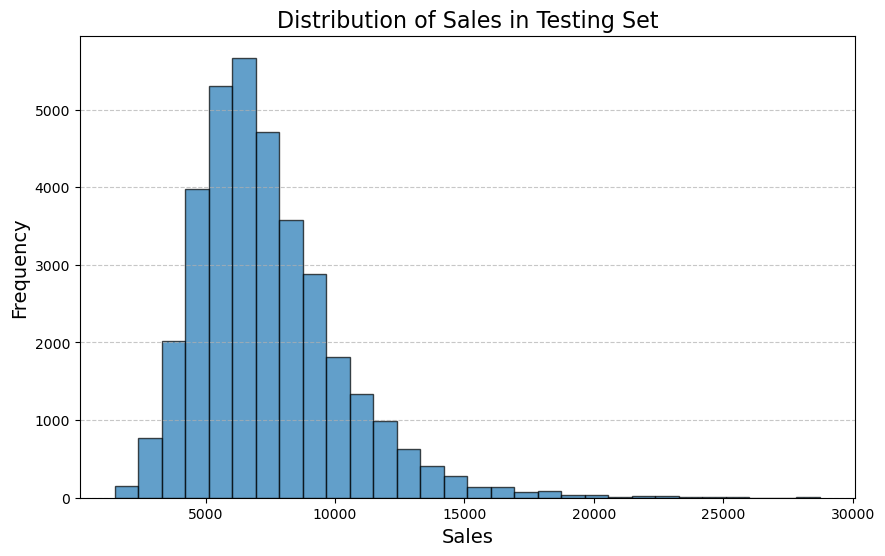

In [90]:
import matplotlib.pyplot as plt

# Drop NaN values in Sales
sales_data = testingSet['Sales'].dropna()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(sales_data, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Sales in Testing Set', fontsize=16)
plt.xlabel('Sales', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [92]:
# Drop NaN values in Sales
sales_data = testingSet['Sales'].dropna()

# Display descriptive statistics
descriptive_stats = sales_data.describe()
print("Descriptive Statistics for Sales in Testing Set:")
print(descriptive_stats)

Descriptive Statistics for Sales in Testing Set:
count    35093.000000
mean      7393.348225
std       2817.119900
min       1500.791333
25%       5480.813032
50%       6890.708342
75%       8801.728363
max      28715.088316
Name: Sales, dtype: float64


In [96]:
testingSet.to_csv('outputFINALudate.csv', index=False)